# "Harris corner detection"
> "Extracting corners in images"

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [computer vision, image analysis, feature extraction]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2
- use_math: true

### Here, we'll see how to detect corners in an image using Harris corner detection technique. Let's first see how we can define corners and edges in an image.



#### Corners are basically location in an image where the variation of intensity function $f(x,y)$ are high both in X and Y-directions. In other words, both partial derivatives - $f_x$ and $f_y$ are large.  

#### On the other hand, edges are locations in an image where the variation of the intensity function $f(x,y)$ is high in certain direction, but low in the orthogonal direction. 

![](https://raw.githubusercontent.com/aizardar/Corner-and-Edge-detection/main/corner_edge.png)

#### Image source - http://dept.me.umn.edu/courses/me5286/vision/VisionNotes/2017/ME5286-Lecture8-2017-InterestPointDetection.pdf

### Below is the outline of the algorithm:


1.   In the first step, we estimate the partial derivatives i.e. intensity gradient in two perpendicular directions, $f_{x} = \frac{\delta f(x,y)}{\delta x}$ and $f_{y} = \frac{\delta f(x,y)}{\delta y}$ for each pixel in the image. 
2. In the second step, we compute the second order moments of partial intesity derivatives i.e. $f_{x}^{2}$, $f_{y}^{2}$, and $f_{x}.f_{y}$.
3. In the third step, second order moments are smoothed isotropically using a two-dimensional Gaussian filter. 
4. In the next step, we compute matrix

\begin{equation*}
A = 
\begin{bmatrix}
g*f_{x}^{2} & g*f_{x}.f_{y} \\
g*f_{x}.f_{y} & g*f_{y}^{2}
\end{bmatrix}
\end{equation*}

 and Harris response, $ R(A) = det(A) - k(trace(A))^2$ 
5. As a final step, we choose the best points for corners by selecting a threshold on the resonse $R(A)$ and apply non-max suppression. 



### Let's start by importing some useful libraries

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.ndimage.interpolation import rotate
from scipy.ndimage.filters import gaussian_filter1d, gaussian_filter
import numpy as np
import cv2  # a library for computer vision tasks.
from skimage import io # a library that supports image processing applications on python.

Image shape =  (640, 618)


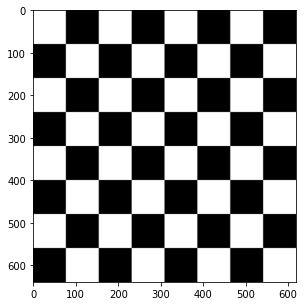

In [3]:
# Define parameters for gaussian filter
sigma_d = 4.0
sigma_w = 2.0

kappa = 0.06 # k 
rot_angle = 0 # rotation angle
thresh = 800 # threshold

# Read the image from url 
image_url = "https://raw.githubusercontent.com/aizardar/Computer-vision/main/Harris%20Corner%20detector/images/chess_board.png"
im = io.imread(image_url)
im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY) # Convert image from RGB to gray scale image

print("Image shape = ", im.shape)
im = im.astype('float')

# Rotate the image if angle not zero 
if rot_angle != 0:
    im = rotate(im, rot_angle)

# Display image
plt.figure(figsize=(5,5))
plt.imshow(im, cmap = 'gray')

### 1. Compute the horizontal and vertical partial derivatives (Gaussian)


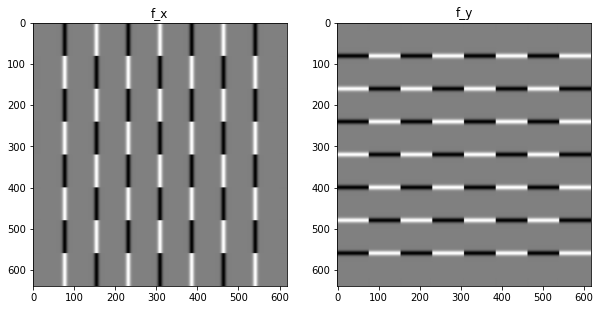

In [4]:
f_x = gaussian_filter1d(im, sigma = sigma_d, axis = 1, order = 1)
f_y = gaussian_filter1d(im, sigma = sigma_d, axis = 0, order = 1)

f, ax_arr = plt.subplots(1, 2, figsize=(10, 12))
ax_arr[0].set_title("f_x")
ax_arr[1].set_title("f_y")
ax_arr[0].imshow(f_x, cmap='gray')
ax_arr[1].imshow(f_y, cmap='gray')

#### One can see that our first-order derivatives $f_{x}$ and $f_{y}$ detects the horizontal and vertical lines in our image.  

### 2. Compute the second-order moments of partial intensity derivatives. 


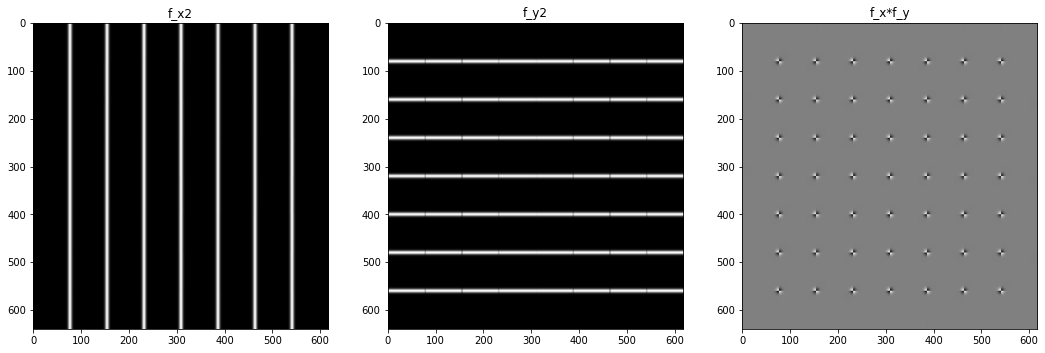

In [5]:
f_x2 = np.square(f_x)
f_y2 = np.square(f_y)
f_x_f_y = f_x*f_y

# Let's plot

f, ax_arr = plt.subplots(1, 3, figsize=(18, 16))
ax_arr[0].set_title("f_x2")
ax_arr[1].set_title("f_y2")
ax_arr[2].set_title("f_x*f_y")
ax_arr[0].imshow(f_x2, cmap='gray')
ax_arr[1].imshow(f_y2, cmap='gray')
ax_arr[2].imshow(f_x_f_y, cmap='gray')

### 3. Apply gaussian filter on second-order moments

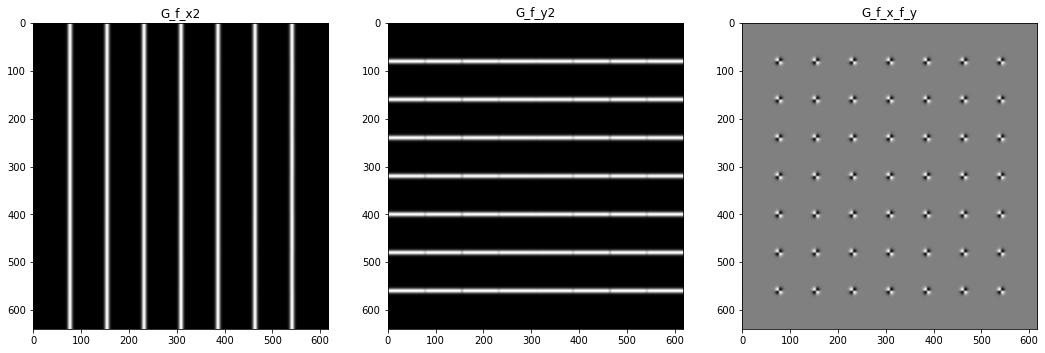

In [6]:
# Convolve each of the three moments with another two-dimensional Gaussian filter. 

G_f_x2 = gaussian_filter(f_x2, sigma = sigma_w)
G_f_y2 = gaussian_filter(f_y2, sigma = sigma_w)
G_f_x_f_y = gaussian_filter(f_x_f_y, sigma = sigma_w)

f, ax_arr = plt.subplots(1, 3, figsize=(18, 16))
ax_arr[0].set_title("G_f_x2")
ax_arr[1].set_title("G_f_y2")
ax_arr[2].set_title("G_f_x_f_y")
ax_arr[0].imshow(G_f_x2, cmap='gray')
ax_arr[1].imshow(G_f_y2, cmap='gray')
ax_arr[2].imshow(G_f_x_f_y, cmap='gray')

#### As one can see, corners are more visible (see rightmost image) after convolving the second order moments with a Gaussian filter. 

### 4. Compute matrix $R(A)$

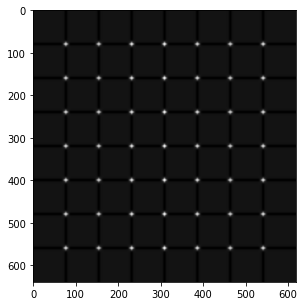

In [7]:
R = G_f_x2*G_f_y2 - G_f_x_f_y*G_f_x_f_y - kappa* np.square(G_f_x2 + G_f_y2)

plt.figure(figsize=(5,5))
plt.imshow(R, cmap = 'gray')

### 5. Find points with large corner response function $R(R > threshold)$ and apply non-max suppression

In [8]:
def nonmax_suppression(harris_resp, thr):
    """
    Outputs:
    # 1) corners_y: list with row coordinates of identified corner pixels.
    # 2) corners_x: list with respective column coordinates of identified corner pixels.
    # Elements from the two lists with the same index must correspond to the same corner.

    Note: non-max suppression
    We take the points of locally maximum R as the detected feature points i.e. pixels where R is bigger than for all the 8 neighbours
    For pixels lying at the boundary of the image, we use np.mod function.  
    """

    corners_y = []
    corners_x = []
    h, w = im.shape[:2]
    for i in range(h):
        for j in range(w):
            if harris_resp[i,j] >= thr and harris_resp[i,j] == max(harris_resp[i,j],\
                                                                   harris_resp[i,np.mod(j+1, w)],\
                                                                   harris_resp[i,np.mod(j-1, w)],\
                                                                   harris_resp[np.mod(i+1, h),j],\
                                                                   harris_resp[np.mod(i-1, h),j],\
                                                                   harris_resp[np.mod(i+1, h),np.mod(j+1, w)], \
                                                                   harris_resp[np.mod(i-1, h),np.mod(j+1, w)], \
                                                                   harris_resp[np.mod(i+1, h),np.mod(j-1, w)], \
                                                                   harris_resp[np.mod(i-1, h),np.mod(j-1, w)]):
                corners_x.append(j)
                corners_y.append(i)

    return corners_y, corners_x

In [9]:
corn = nonmax_suppression(R,thresh)

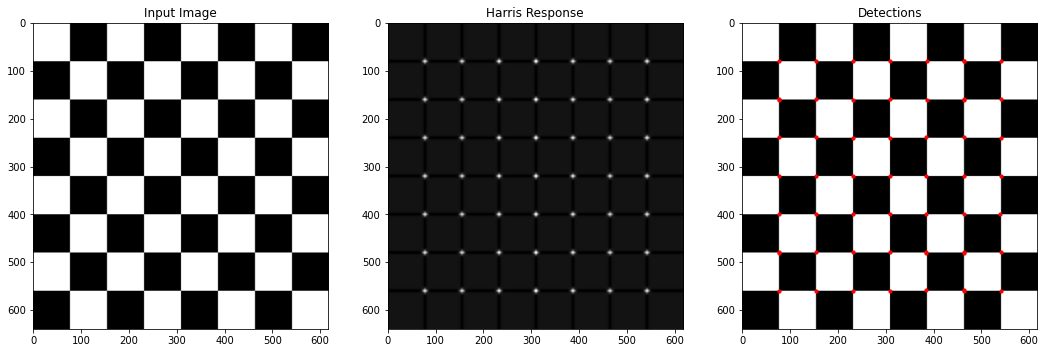

In [10]:
# Plotting of results
# plt.close("all")
# plt.ion()
# plt.gray()
f, ax_arr = plt.subplots(1, 3, figsize=(18, 16))
ax_arr[0].set_title("Input Image")
ax_arr[1].set_title("Harris Response")
ax_arr[2].set_title("Detections")
ax_arr[0].imshow(im, cmap='gray')
ax_arr[1].imshow(R, cmap='gray')
ax_arr[2].imshow(im, cmap='gray')
ax_arr[2].scatter(x=corn[1], y=corn[0], c='r', s=10)

#### As we can see, our algorithm detected corners (shown by red dots) in the chess board. 

#### One can also easily see that the Harris corner detector is rotation invariant i.e. the algorithm still detects corners if the image is rotated. Just change the rotation angle from 0 to any value. This can be done by setting rot_angle parameter in the beginning of this notebook.   

####  Feel free to play with this notebook. One can try detecting corners on new images but keep in mind that one may have to tune some parameters e.g. sigma_d, sigma_w, threshold, etc., to correctly identify corners.   

#### Let me know if you have any comments or suggestions.

References:


1.   http://dept.me.umn.edu/courses/me5286/vision/VisionNotes/2017/ME5286-Lecture8-2017-InterestPointDetection.pdf
2. https://colab.research.google.com/github/xn2333/OpenCV/blob/master/Image_Processing_in_Python_Final.ipynb#scrollTo=Tz7UAjxjfMuz   

